In [1]:
from gensim import corpora
from gensim import models
import numpy as np
from scipy.sparse import csr_array
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import pandas as pd

from motifs.dataloader import CanonData
from motifs.features import bow_to_matrix, bow_to_dataframe
from motifs.plots import silhouette_plot, plot_clusters
from motifs.utils import filter_token_by_freq

# Load data

- Get metadata
- Load the 5-grams that were precomputed using a subcorpus of the "canon" corpus.
    - This subcorpus was built by selecting at most 50 texts at random per period, which are defined in `motifs.dataloader.CanonData`, e.g 1800-1826, 1827-1850, 1851-1869, 1870-1899, 1900-1945, 1946-2024.
    - We have in total 217 documents
    - Remove tokens that appear only once in each document in the corpus

In [2]:
NGRAMS_PATH = "/Users/brunospilak/Documents/Sorbonne/PyMotifs/data_backup/ngrams_canon.csv"
METADATA_PATH = "../data/canon/metadata.csv"

In [3]:
# Load metadata
metadata = CanonData(METADATA_PATH)
data = metadata.data.set_index("doc_id")

# Load 5-grams, about 1.6GB in RAM
ngrams = pd.read_csv(NGRAMS_PATH, index_col=0)
docs = list(set(ngrams.doc.unique()))
# Get the metadata for the subcorpus
data = data.loc[docs]

# Remove tokens that appear only once, this can take a while since ngrams has more than 15 Million rows
t1 = time.time()
ngrams = filter_token_by_freq(ngrams, 1, groupby="doc")
t2 = time.time()
print(f"Done in {t2-t1:.2f} secs")

Done in 81.58 secs


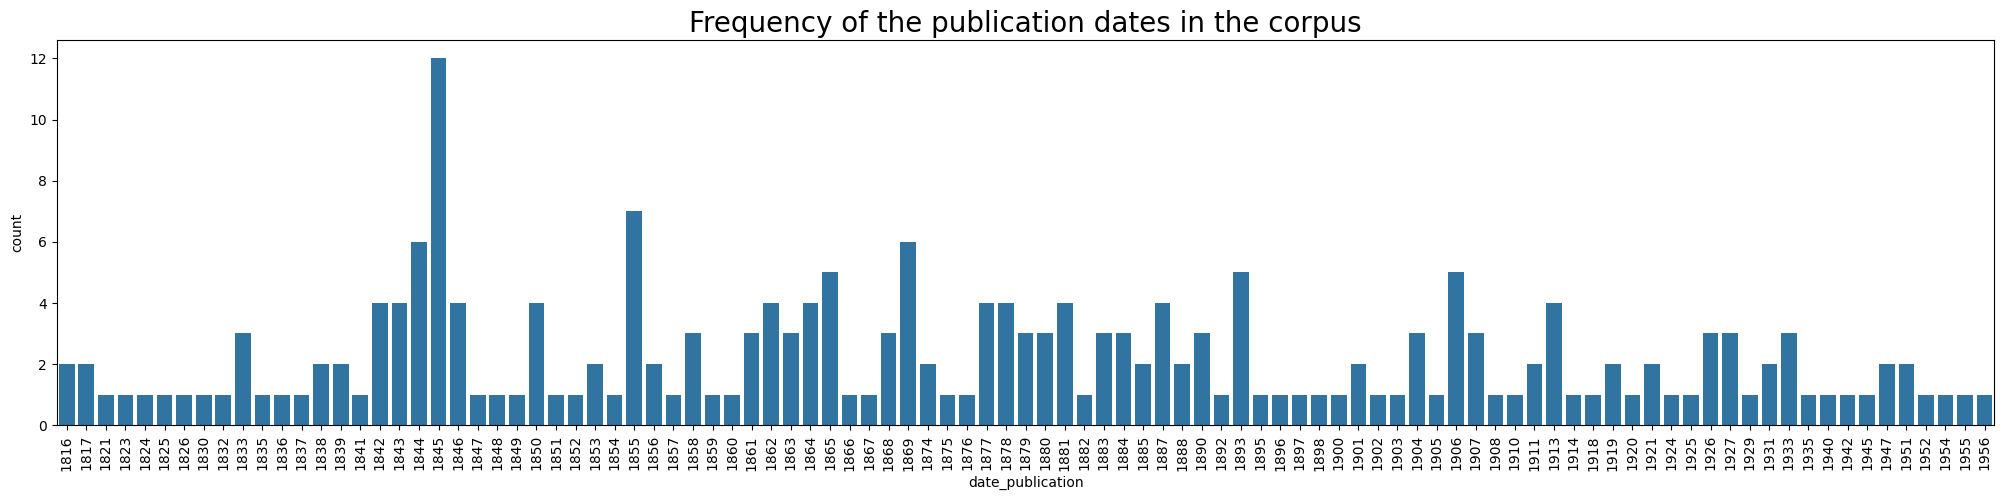

In [4]:
plt.figure(figsize=(25,5))
sns.barplot(data["date_publication"].value_counts())
plt.xticks(rotation=90)
plt.title("Frequency of the publication dates in the corpus", size=20)
plt.show()

# TFIDF

Now, compute TFIDF with Gensim and store them in a sparse matrix.

Note: **Gensim normalizes the tfidf vectors by default. However, as we do not select all dimensions in the vector, we do not normalize the vector directly, we will do it after feature selection.**

We use a very simple feature selection method. We keep only the less sparse features, for example the first $n$ features ($n=10000$). As a measure for sparsity, we simply compute the frequency of non-zeros elements: the larger the frequency, the less sparse the feature is.

In [5]:
t1 = time.time()
# Create dictionary with gensim
texts = [
    ngrams[ngrams["doc"] == d]["token"].tolist() for d in docs
]
dictionary = corpora.Dictionary(texts)
# Get Bag of words representation
bow_corpus = [dictionary.doc2bow(text) for text in texts]
# Fit the tfidf
model = models.TfidfModel(bow_corpus, normalize=False)
# Create a sparse matrix
mat_tfidf = bow_to_matrix([model[d] for d in bow_corpus], shape=(len(bow_corpus), len(dictionary.token2id)))
t2 = time.time()
print(f"Done in {t2-t1:.2f} secs")

Done in 49.98 secs


In [6]:
# Keep the n less sparse features
n = 10000
freq_nonzeros = np.sum(mat_tfidf.toarray() != 0, axis=0) / mat_tfidf.shape[0]
selected = np.argsort(freq_nonzeros)[-n:]
features = mat_tfidf[:,selected]

# Save names of columns and indices
index=docs
columns = list({id_: dictionary[id_] for id_ in selected})
features.shape


(217, 10000)

# Clustering

We have 10000 features and 217 documents. The features are TFIDF features, thus definitely not gaussian. We can expect KMeans to perform very badly on the raw table. On top, we can suspect non-linear relationship between the documents.

We propose to use a manifold learning techning, TSNE, to reduce the dimension of the feature spaces. TSNE helps use to visualize potential clusters in the dataset.

In [7]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn import metrics

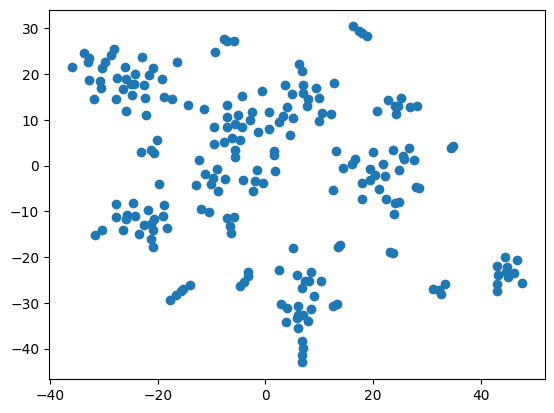

In [236]:
# First, we normalize each TFIDF vector
X = normalize(features, norm='l2', axis=1)

# Simply for reproduction
random_state=1
np.random.seed(random_state)
# We use a relatively small perplexity to exhibit local patterns
embedding = TSNE(
    n_components=2, init='random', random_state=random_state, perplexity=5, 
).fit_transform(X)
plt.scatter(x=embedding[:,0], y=embedding[:,1])
plt.show()

We can observe some clusters. 

**note: TSNE is not deterministic even when setting random_state. The results might look different across multiple runs. It is worth testing the sensitivity of the intrepretation with various random_state and runs. We noticed quite stable results for the Balzac, Verne, and Delly clusters.**

In the next step, we use DBSCAN method to find the clusters, since it does not require to specify the number of clusters.

Silhouette DBSCAN 0.5701857


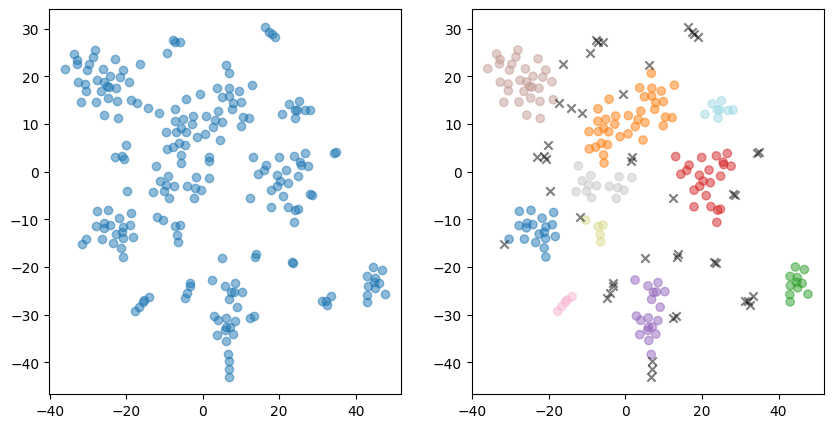

In [248]:
# The minimum size of a cluster is set to 5 documents to found a reasonable amount of clusters
# eps depends on the distance between points in the embedding space
# We could tune these parameters using a criterion, for example the Silhouette score. We do not do that here.

clusterer = DBSCAN(eps=4, min_samples=5, metric="euclidean")
cluster_labels = clusterer.fit_predict(embedding)
clustered_points = np.array(range(len(embedding)))[cluster_labels != -1]
silhouette_avg = metrics.silhouette_score(embedding[clustered_points, :], cluster_labels[clustered_points], metric='euclidean')
print("Silhouette DBSCAN", silhouette_avg)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(x=embedding[:,0], y=embedding[:,1], alpha=0.5)
scatter = axs[1].scatter(
    x=embedding[cluster_labels != -1, 0], 
    y=embedding[cluster_labels != -1, 1], 
    c=cluster_labels[cluster_labels != -1], cmap="tab20", alpha=0.5
)
axs[1].scatter(
    x=embedding[cluster_labels == -1,0], 
    y=embedding[cluster_labels == -1,1], 
    marker="x",
    c="black",
    alpha=0.5,
)

plt.show()

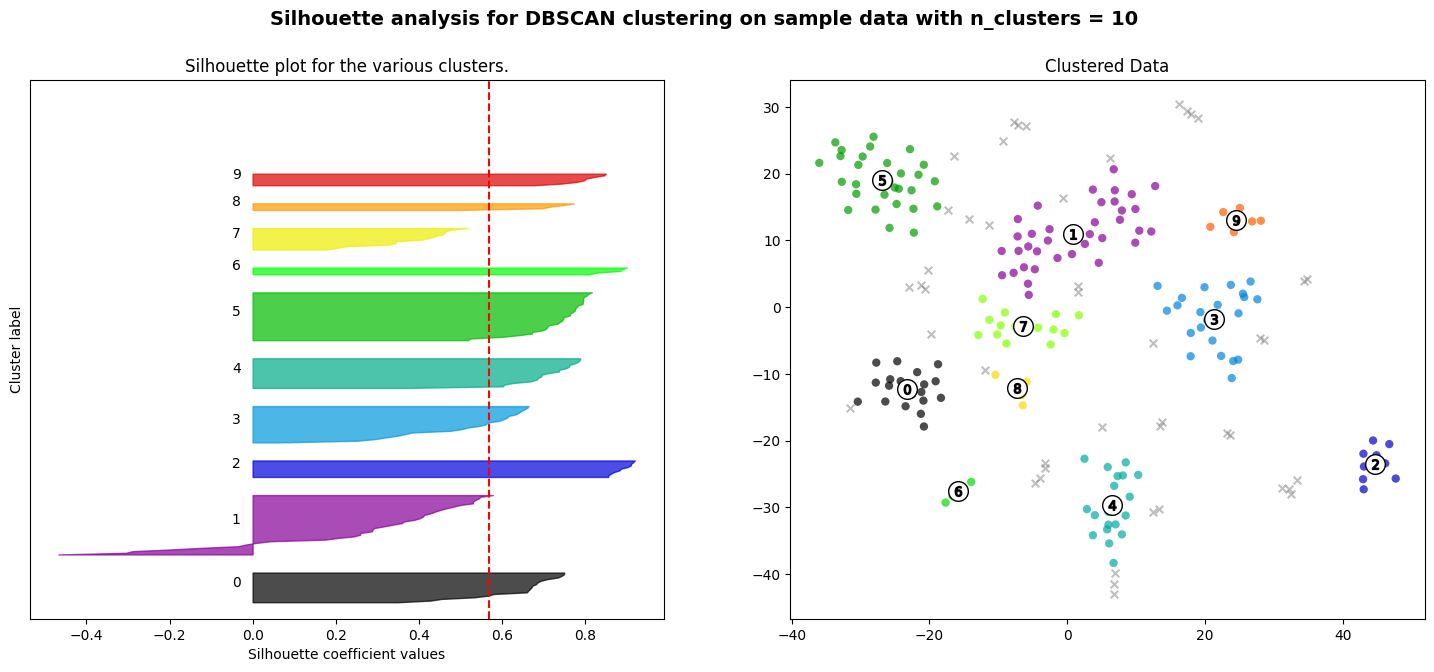

In [244]:
sample_silhouette_values = silhouette_plot(embedding, cluster_labels)

We observe that DBSCAN found 10 clusters, the grey cross points being classified as noise.

From the silhouette plot above, we observe that the a part from cluster 1, all clusters are quite dense with respect to the Euclidean distance. A few negative silhouette scores in cluster 1 indicate that some samples in these clusters might belong to another cluster or should be classified as noise. Indeed from the thickness of the silhouette, we deduce that cluster 1 is larger than the other cluster and contain maybe hetereogenous samples.
However the other clusters are quite dense and the average silhouette score of 0.57 shows that the clusters found by DBSCAN are well defined with respect to the euclidean distance.
Let us confirm this by looking into the constitutions of the clusters.

In [249]:
clusters = {str(c): [] for c in cluster_labels}
for i, d in enumerate(docs):
    clusters[str(cluster_labels[i])].append(d)
# Save the clusters
# json.dump(clusters, aopen("clusters.json", "w"))
clusters

{'0': ['1845_Balzac-Honore-de_La-Recherche-de-l-Absolu',
  '1843_Balzac-Honore-de_Histoire-des-Treize',
  '1844_Chateaubriand-François-Rene-de_Vie-de-Rance',
  '1845_Balzac-Honore-de_Sur-Catherine-de-MedicisFC',
  '1855_Balzac-Honore-de_Les-PaysansFC',
  '1844_Balzac-Honore-de_La-Maison-Nucingen',
  '1845_Balzac-Honore-de_Gambara',
  '1842_Balzac-Honore-de_Madame-Firmiani',
  '1845_Balzac-Honore-de_Un-debut-dans-la-vieFC',
  '1845_Balzac-Honore-de_Un-drame-au-bord-de-la-merFC',
  '1844_Balzac-Honore-de_Sarrasine',
  '1846_Balzac-Honore-de_Un-prince-de-la-Boheme',
  '1846_Balzac-Honore-de_Autre-etude-de-femme',
  '1844_Balzac-Honore-de_L-InterdictionFC',
  '1844_Balzac-Honore-de_La-Messe-de-l-atheeFC',
  '1843_Balzac-Honore-de_Ursule-Mirouet',
  '1843_Balzac-Honore-de_Le-Pere-GoriotFC',
  '1845_Balzac-Honore-de_Le-RequisitionnaireFC',
  '1855_Balzac-Honore-de_Les-Petits-BourgeoisFC'],
 '1': ['1826_Ginouvier-J-F-T._Gustave-et-Aspais-ou-Les-victimes-des-prejuges-de-l-epoque-tome-1',
  '1

# Clusters interpretation based on the metadata

In [250]:
data["cluster"] = cluster_labels

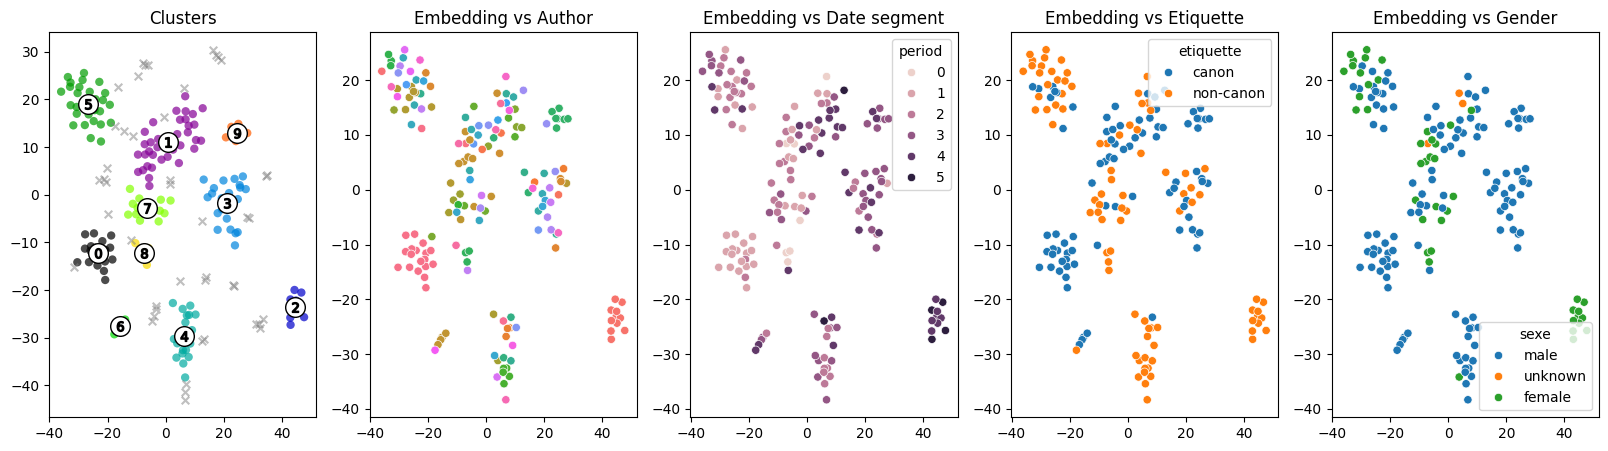

In [251]:
fig, axs = plt.subplots(1, 5, figsize=(20,5))
# Cluters
plot_clusters(embedding, cluster_labels, ax=axs[0], title="Clusters")

# Author
sns.scatterplot(x=embedding[cluster_labels!=-1,0], y=embedding[cluster_labels!=-1,1], 
                hue=data.loc[cluster_labels!=-1, "author"], legend=False, ax=axs[1])
axs[1].set_title("Embedding vs Author")
# Date
sns.scatterplot(x=embedding[cluster_labels!=-1,0], y=embedding[cluster_labels!=-1,1], 
                hue=data.loc[cluster_labels!=-1, "period"], ax=axs[2])
axs[2].set_title("Embedding vs Date segment")

# Etiquette
sns.scatterplot(x=embedding[cluster_labels!=-1,0], y=embedding[cluster_labels!=-1,1], 
                hue=data.loc[cluster_labels!=-1, "etiquette"], ax=axs[3])
axs[3].set_title("Embedding vs Etiquette")

# Gender
sns.scatterplot(x=embedding[cluster_labels!=-1,0], y=embedding[cluster_labels!=-1,1], 
                hue=data.loc[cluster_labels!=-1, "sexe"], ax=axs[4])
axs[4].set_title("Embedding vs Gender")

plt.show()

From the plot above, it seems that the author variable can help interpret the cluster. Indeed, cluster 0, 2, and 9, seem to correspond to one author. The publication date, Etiquette, and Gender are dependent on the author.

On top, out of the 113 different authors reprensented in the corpus only 8 have texts groupped in different clusters. This is shown in the output below listing the clusters that have authors in common. For example, both cluster 0 and 5 contain texts written by Balzac.

In [265]:
labels = list(set(cluster_labels[cluster_labels != -1]))
pairs = [(a, b) for idx, a in enumerate(labels) for b in labels[idx + 1:]]
authors_overlap = {}
authors_overlap_id = []
for p in pairs:
    o = set(data.loc[cluster_labels==p[0], "author"]).intersection(
        set(data.loc[cluster_labels==p[1], "author"])
    )
    if len(o) > 0:
        authors_overlap[p] = o
        authors_overlap_id.extend(list(o))
print(len(set(authors_overlap_id)))
authors_overlap



8


{(0, 5): {'Balzac, Honoré de'},
 (1, 3): {'Apollinaire, Guillaume'},
 (1, 5): {'Fleuriot, Zénaïde'},
 (1, 7): {'Sand, George', 'Sue, Eugène'},
 (3, 5): {'Leblanc, Maurice'},
 (3, 8): {'Leblanc, Maurice'},
 (3, 9): {'Daudet, Alphonse'},
 (5, 7): {'Dumas (père), Alexandre'},
 (5, 8): {'Leblanc, Maurice'}}

## Contingency table

Another usefull statistics for categorical variables are contingency table. For example, we can ask ourselves: *What is the probability that a document in cluster $j$ is written by author $i$?*, *What is the probability that a document written by author $i$ is located in cluster $j$?*, *What is the probability that a document is written by a female in cluster $i$?* etc.


#### Author vs Cluster

In [266]:
crosstab_cluster_y = pd.crosstab(data["author"].astype("category"), data["cluster"].astype("category"))
crosstab_cluster_y

cluster,-1,0,1,2,3,4,5,6,7,8,9
author,,,,,,,,,,,
"About, Edmond",0,0,0,0,0,0,2,0,0,0,0
"Aimard, Gustave",0,0,0,0,0,0,0,0,1,0,0
"Albalat, Antoine",0,0,0,0,1,0,0,0,0,0,0
"Apollinaire, Guillaume",0,0,1,0,1,0,0,0,0,0,0
"Arlincourt, Charles-Victor Prévost d'",0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
"Verne, Jules",1,0,0,0,0,0,0,4,0,0,0
"Vesco, Marie Delorme, Mme Léon",0,0,0,0,0,0,1,0,0,0,0
"Villiers de l'Isle-Adam, Auguste",1,0,1,0,0,0,0,0,0,0,0


**What is the probability that a document in cluster $i$ is written by Balzac?**

*95%* in cluster 0. Balzac is clearly overrepresented in cluster 0

In [269]:
# Sum by columns (clusters)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=0).values.reshape(1,-1)) * 100
df.loc[["Balzac, Honoré de"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9
author,,,,,,,,,,,
"Balzac, Honoré de",4,95,0,0,0,0,3,0,0,0,0


**What is the probability that a document written by Balzac belongs to cluster $i$?**

Cluster 0 representes *86%* of Balzac texts.

In [271]:
# Sum by row (author)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=1).values.reshape(-1,1)) * 100
df.loc[["Balzac, Honoré de"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9
author,,,,,,,,,,,
"Balzac, Honoré de",10,86,0,0,0,0,5,0,0,0,0


We can already say that cluster 0 mostly represent Balzac style as 86% of Balzac texts are in cluster 0 and 95% of the documents belonging to cluster 0 are from Balzac.

#### Gender vs Cluster

In [272]:
crosstab_cluster_y = pd.crosstab(data["sexe"].astype("category"), data["cluster"].astype("category"))
crosstab_cluster_y

cluster,-1,0,1,2,3,4,5,6,7,8,9
sexe,,,,,,,,,,,
female,7,0,10,11,0,1,13,0,6,3,0
male,39,19,23,0,23,18,17,5,8,2,8
unknown,0,0,3,0,0,0,0,0,0,0,0


**What is the probability that a document in cluster $i$ is written by Female?**

100% for cluster 2.

In [275]:
# Sum by columns (clusters)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=0).values.reshape(1,-1)) * 100
df.loc[["female"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9
sexe,,,,,,,,,,,
female,15,0,28,100,0,5,43,0,43,60,0


**What is the probability that a document written by a female belongs to cluster $i$?**

Cluster 4 representes *25%* of texts written by female authors.

In [277]:
# Sum by row (author)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=1).values.reshape(-1,1)) * 100
df.loc[["female"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9
sexe,,,,,,,,,,,
female,14,0,20,22,0,2,25,0,12,6,0


# Publication date vs Cluster

In [278]:
crosstab_cluster_y = pd.crosstab(data["period"].astype("category"), data["cluster"].astype("category"))
crosstab_cluster_y = crosstab_cluster_y.set_index(metadata.periods["start"].astype(str) + " - " + metadata.periods["end"].astype(str))

In [285]:
crosstab_cluster_y.sum(axis=1)/sum(crosstab_cluster_y.sum(axis=1))

1800 - 1826    0.041475
1827 - 1850    0.230415
1851 - 1869    0.230415
1870 - 1899    0.230415
1900 - 1945    0.230415
1946 - 2024    0.036866
dtype: float64

**What is the probability that a document in cluster $i$ was published at a given date?**

In cluster 5, 43% of the texts were published between 1851 and 1869 which is almost 2 times larger than in the corpus. This period is overrepresented in this cluster. 90% of them were published between 1827 and 1900, 30% more than in the corpus.

In [286]:
# Sum by columns (clusters)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=0).values.reshape(1,-1)) * 100
df.style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9
1800 - 1826,4,0,8,0,0,0,0,0,7,60,0
1827 - 1850,28,89,22,0,4,0,23,0,29,0,0
1851 - 1869,13,11,27,0,17,42,43,20,36,20,0
1870 - 1899,13,0,14,0,52,42,23,40,29,0,75
1900 - 1945,37,0,27,64,26,11,10,40,0,20,25
1946 - 2024,4,0,3,36,0,5,0,0,0,0,0


**What is the probability that a document published at a given date belongs to cluster $i$?**

More than a quarter of the texts that were published between 1851 and 1869 belongs to cluster 5. This is the largest score. It is fair to interpret cluster 5 as one describing well a part of the literature of the Second Empire in France.

In [281]:
# Sum by columns (clusters)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=1).values.reshape(-1,1)) * 100
df.style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9
1800 - 1826,22,0,33,0,0,0,0,0,11,33,0
1827 - 1850,26,34,16,0,2,0,14,0,8,0,0
1851 - 1869,12,4,20,0,8,16,26,2,10,2,0
1870 - 1899,12,0,10,0,24,16,14,4,8,0,12
1900 - 1945,34,0,20,14,12,4,6,4,0,2,4
1946 - 2024,25,0,12,50,0,12,0,0,0,0,0


## Cluster interpretation with respect to authors

In [291]:
def plot_one_cluster(label, figsize=(15,5)):
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    scatter = axs[0].scatter(
        embedding[:,0], embedding[:,1],  c=["red" if i else "grey" for i in cluster_labels==label],
        alpha=0.5
    )
    axs[0].set_title("Feature space")
    
    authors = data.loc[cluster_labels==label, "author"].astype("category")
    axs[1].scatter(embedding[cluster_labels!=label,0], embedding[cluster_labels!=label,1], c="grey", alpha=0.5)
    scatter = axs[1].scatter(
        embedding[cluster_labels==label][:,0], embedding[cluster_labels==label][:,1], 
        c=authors.cat.codes, alpha=1, cmap=None if len(authors.unique()) < 10 else "tab20"
    )
    # produce a legend with the unique colors from the scatter
    legend = axs[1].legend(
        scatter.legend_elements()[0], [a.split(",")[0] for a in authors.cat.categories.tolist()], 
        title="Author",
    )
    axs[1].add_artist(legend)
    axs[1].set_title("Authors in the feature space within cluster %d" % label)

    unique_authors = authors.unique()
    axs[2].bar(unique_authors, authors.value_counts(), color="grey")
    # axs[2].set_yticks(np.arange(0, 1.1, 0.1), ["%.1f" % d for d in np.arange(0, 1.1, 0.1)])
    axs[2].set_xticks(range(len(unique_authors)), [a.split(",")[0] for a in unique_authors], rotation=90)
    axs[2].set_title("Author frequency within cluster %d" % label)
    plt.show()

We only consider the clusters with a large Silhouette score:

In [294]:
[c for c in set(cluster_labels) if silhouette_avg < np.mean(sample_silhouette_values[cluster_labels==c])]

[0, 2, 4, 5, 6, 8, 9]

**Cluster 0**

### Cluster constitution

Cluster 0 contains mostly texts written by Balzac:

In [295]:
data.loc[data["cluster"] == 0, "author"]

doc_id
1845_Balzac-Honore-de_La-Recherche-de-l-Absolu                      Balzac, Honoré de
1843_Balzac-Honore-de_Histoire-des-Treize                           Balzac, Honoré de
1844_Chateaubriand-François-Rene-de_Vie-de-Rance     Chateaubriand, François-René de
1845_Balzac-Honore-de_Sur-Catherine-de-MedicisFC                    Balzac, Honoré de
1855_Balzac-Honore-de_Les-PaysansFC                                 Balzac, Honoré de
1844_Balzac-Honore-de_La-Maison-Nucingen                            Balzac, Honoré de
1845_Balzac-Honore-de_Gambara                                       Balzac, Honoré de
1842_Balzac-Honore-de_Madame-Firmiani                               Balzac, Honoré de
1845_Balzac-Honore-de_Un-debut-dans-la-vieFC                        Balzac, Honoré de
1845_Balzac-Honore-de_Un-drame-au-bord-de-la-merFC                  Balzac, Honoré de
1844_Balzac-Honore-de_Sarrasine                                     Balzac, Honoré de
1846_Balzac-Honore-de_Un-prince-de-la-Boheme   

### Balzac cluster classification

85% of the texts written by Balzac are clustered in cluster 0

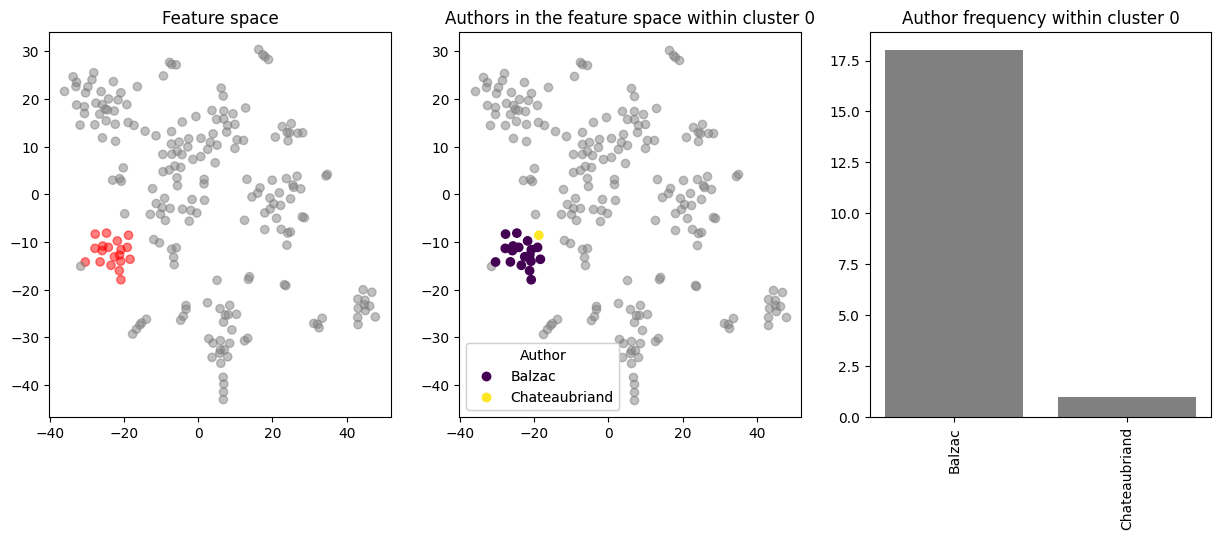

In [298]:
plot_one_cluster(0)

We observe that within cluster 0, only one document is not written by Balzac: Vie de Rancé written by Châteaubriand, who is contempory from Balzac. The document is located at the boundary of the cluster, in particular Stendhal's novel with a silhouette score of 0.43 which is in the worst decile of the silhouette scores of cluster with an average 0.63.

On top, only one text by Balzac is included in another cluster, thus we can interpret cluster 0 as the one representing Balzac texts.

**Cluster 2**

Cluster 2 represents Delly: all texts written by Delly are groupped in cluster 2 and all texts in cluster 2 are written by Delly.

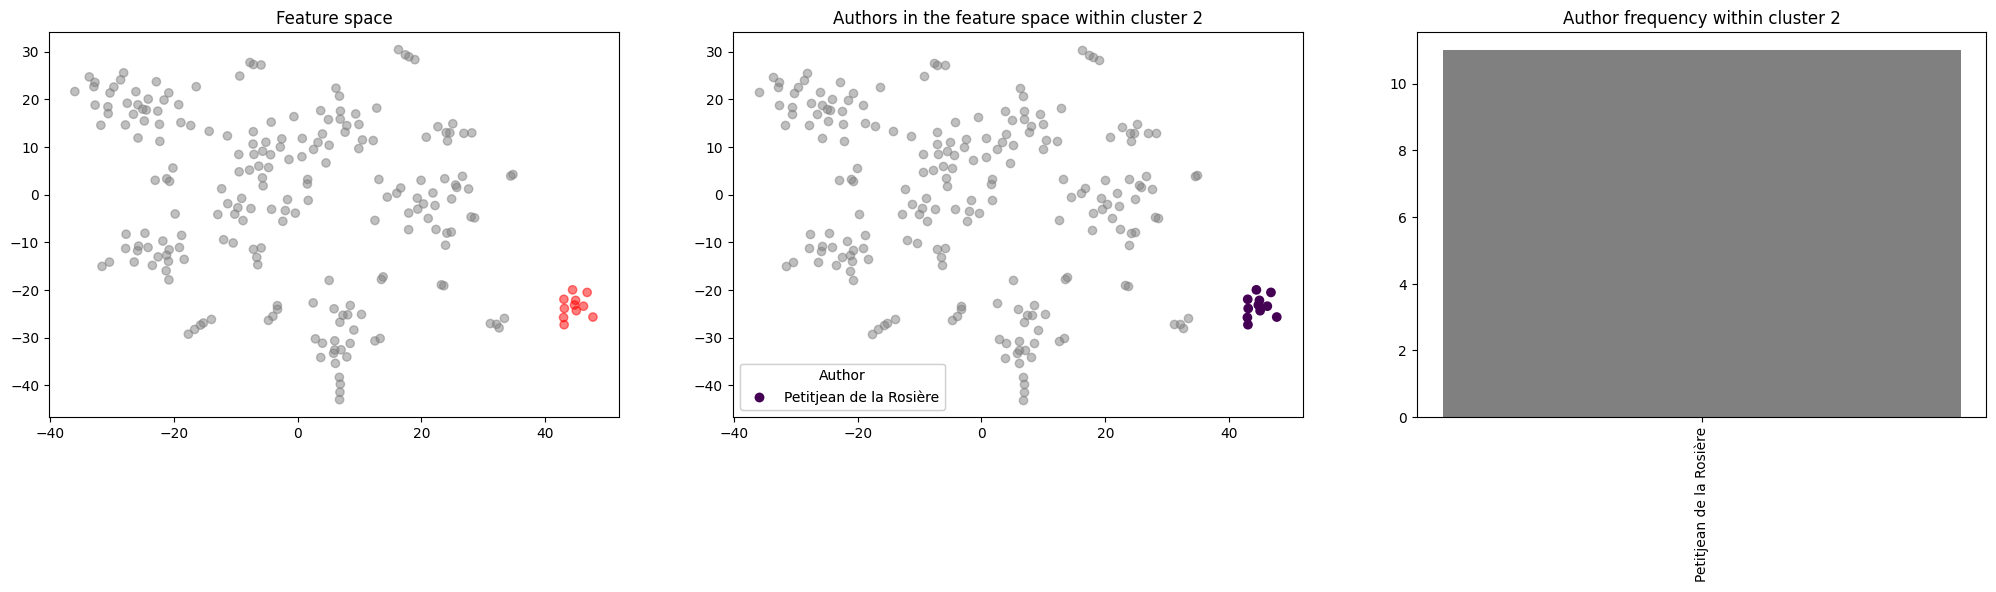

In [309]:
plot_one_cluster(2, figsize=(25,5))

In [319]:
crosstab_cluster_y = pd.crosstab(data["author"].astype("category"), data["cluster"].astype("category"))
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=0).values.reshape(1,-1)) * 100
df.loc[["Petitjean de la Rosière, Jeanne-Marie"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9
author,,,,,,,,,,,
"Petitjean de la Rosière, Jeanne-Marie",0,0,0,100,0,0,0,0,0,0,0


In [320]:
# Sum by row (author)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=1).values.reshape(-1,1)) * 100
df.loc[["Petitjean de la Rosière, Jeanne-Marie"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9
author,,,,,,,,,,,
"Petitjean de la Rosière, Jeanne-Marie",0,0,0,100,0,0,0,0,0,0,0


**Cluster 4**

Cluster 4 is very diverse in terms of author and cannot be interpreted with respect to this metadata. However, Paul Féval (père) is 8.9 times more represented in cluster 4 compared to the original corpus.

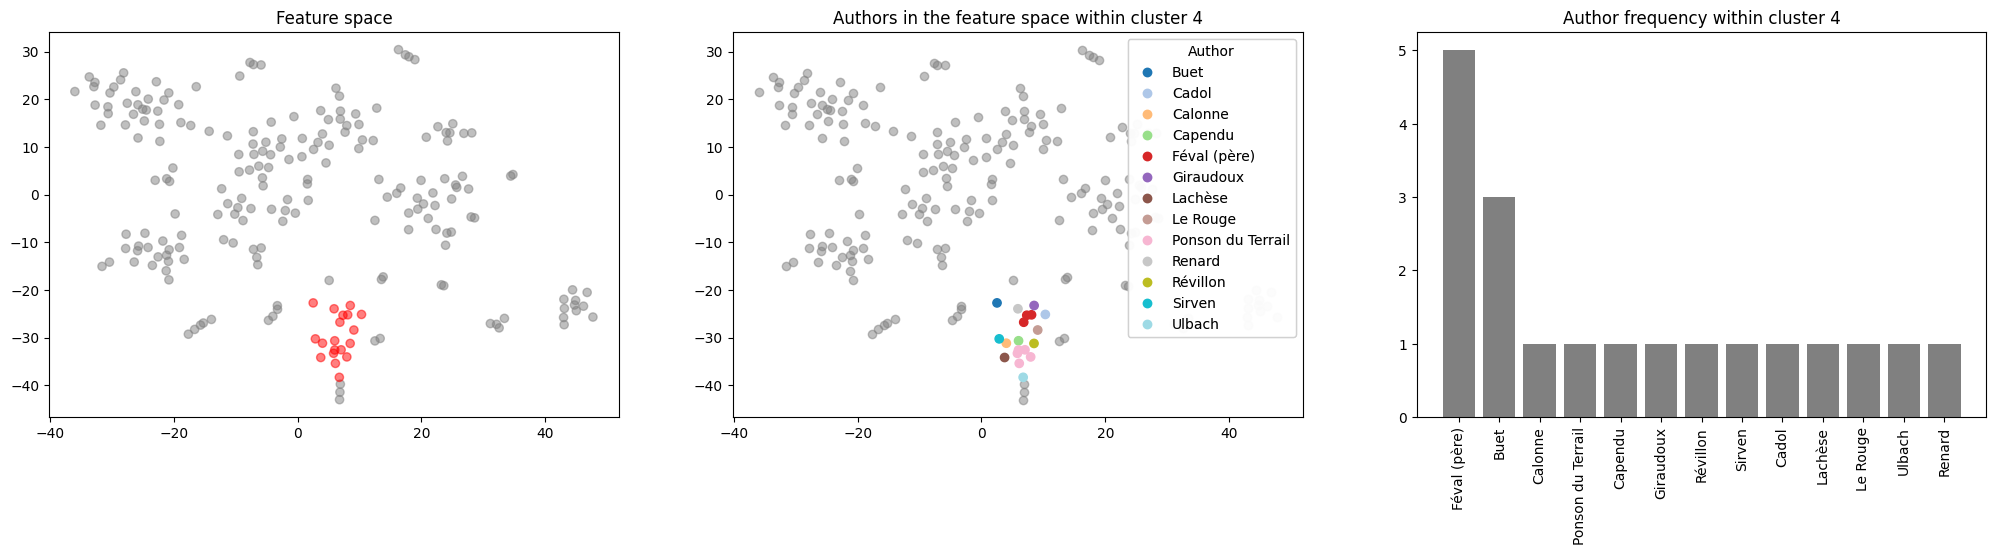

In [321]:
plot_one_cluster(4, figsize=(25,5))

In [330]:
crosstab_cluster_y = pd.crosstab(data["author"].astype("category"), data["cluster"].astype("category"))
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=0).values.reshape(1,-1)) * 100
df.loc[["Féval (père), Paul"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9
author,,,,,,,,,,,
"Féval (père), Paul",2,0,0,0,0,16,0,0,0,0,0


In [331]:
np.sum(data["author"] == "Féval (père), Paul") / len(data)


0.018433179723502304

**Cluster 5**

Cluster 5 is also quite diverse in terms of author.

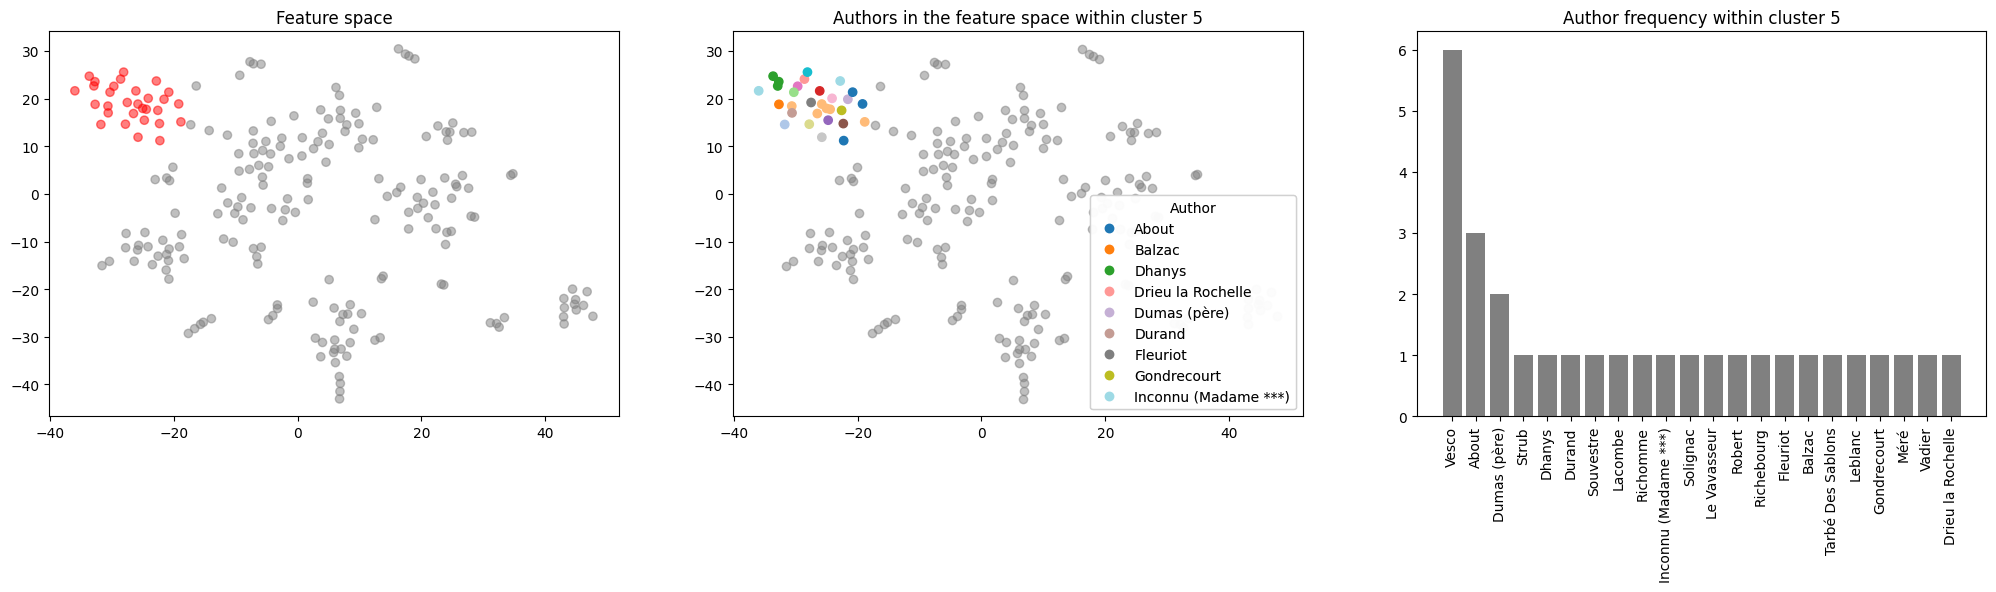

In [344]:
plot_one_cluster(5, figsize=(25,5))

**Cluster 6**

Cluster 6 represents Jules Vernes:
- 80% of the texts written by Jules Vernes are clustered in this group
- 80% of the texts in cluster 6 are written by Jules Vernes, 40 times more than in the original corpus

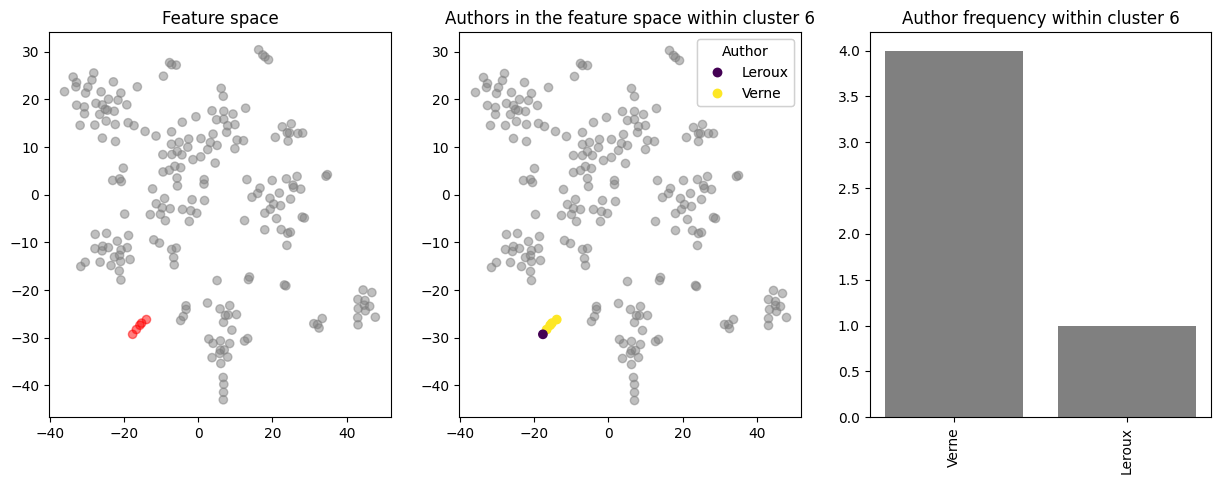

In [346]:
plot_one_cluster(6, figsize=(15,5))

In [350]:
crosstab_cluster_y = pd.crosstab(data["author"].astype("category"), data["cluster"].astype("category"))
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=0).values.reshape(1,-1)) * 100
df.loc[["Verne, Jules"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9
author,,,,,,,,,,,
"Verne, Jules",2,0,0,0,0,0,0,80,0,0,0


In [352]:
sum(data["author"] == "Verne, Jules")/len(data)

0.02304147465437788

**Cluster 8**

Is a small cluster mostly containing documents by Barthélemy-Hadot.

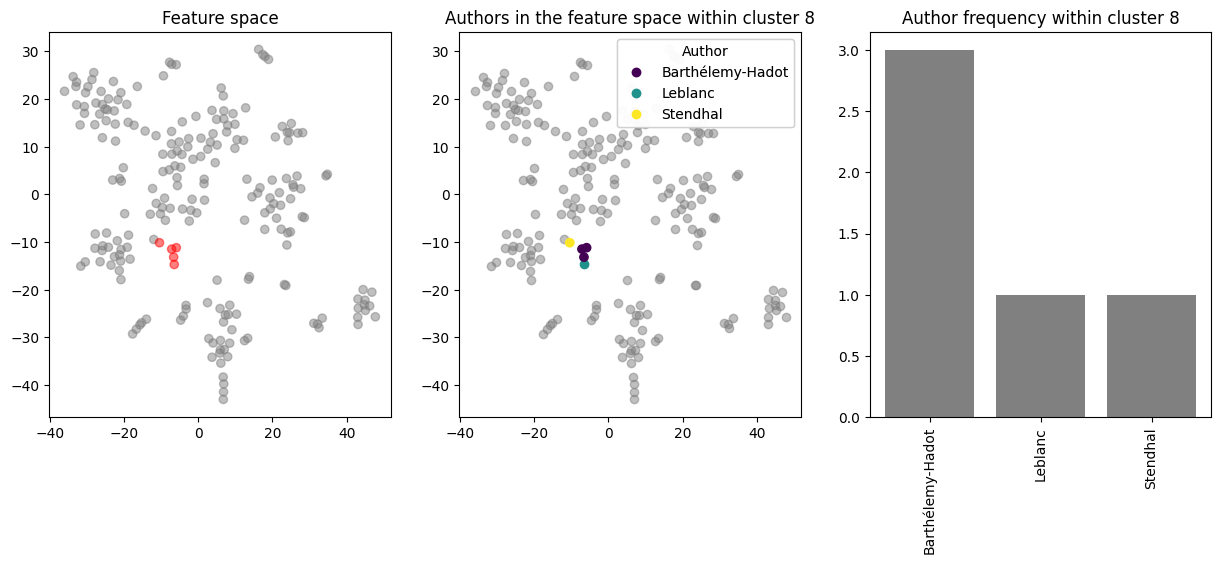

In [354]:
plot_one_cluster(8, figsize=(15,5))

**Cluster 9**

This cluster corresponds to Pierre Loti's motifs.

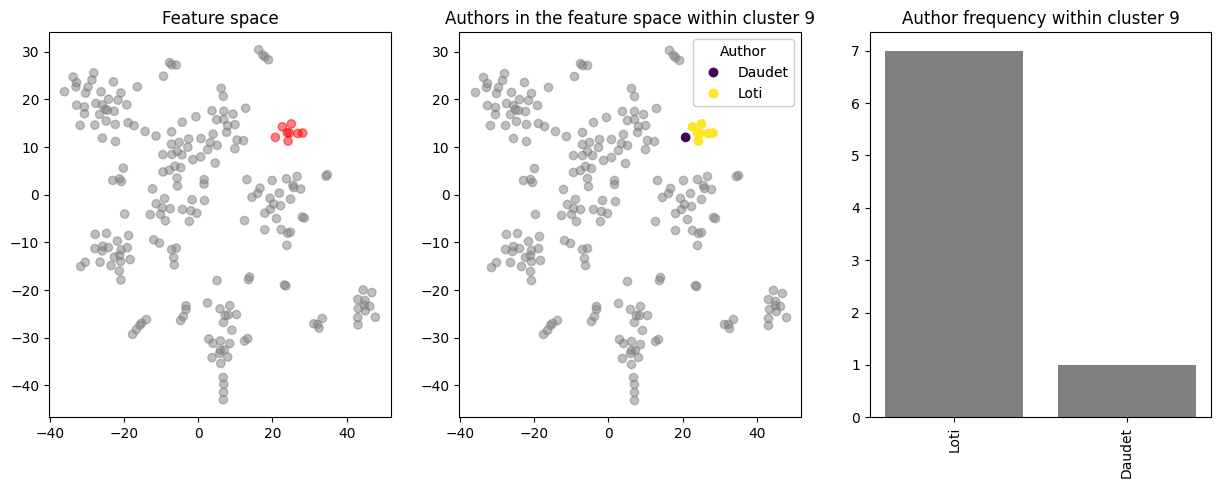

In [356]:
plot_one_cluster(9, figsize=(15,5))